In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import os
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
from tqdm.auto import tqdm

In [2]:
data_dir = 'data/Subha_data/'
folder_list = ['images_001', 'images_002', 'images_003', 'images_004', 'images_005', 'images_006', 'images_007','images_008', 'images_009', 'images_010', 'images_011', 'images_012']
folder_list = [data_dir + folder +'/images' for folder in folder_list]
with open(data_dir+'test_list.txt') as f:
    test_images = f.readlines()
with open(data_dir+'train_val_list.txt') as f:
    train_images = f.readlines()
test_images = [image_name[:-1] for image_name in test_images]
train_images = [image_name[:-1] for image_name in train_images]
label_csv_data = pd.read_csv(data_dir + 'Data_Entry_2017.csv')
# Dropping places where age is greater than 100. We have 16 such values
incorrect_age_mask = label_csv_data['Patient Age'] > 100
incorrect_age_images = label_csv_data[incorrect_age_mask]['Image Index'].tolist()
label_csv_data_filtered = label_csv_data[~incorrect_age_mask]
train_images_filtered = [image for image in train_images if image not in incorrect_age_images]
test_images_filtered = [image for image in test_images if image not in incorrect_age_images]
train_val_images_filtered = set(train_images_filtered)
test_images_filtered_set = set(test_images_filtered)
train_val_mask_filtered = label_csv_data_filtered['Image Index'].isin(train_val_images_filtered)
test_mask_filtered = label_csv_data_filtered['Image Index'].isin(test_images_filtered_set)
removed_images_count = len(incorrect_age_images)

label_csv_data = label_csv_data_filtered
test_images = test_images_filtered 
train_images = train_images_filtered

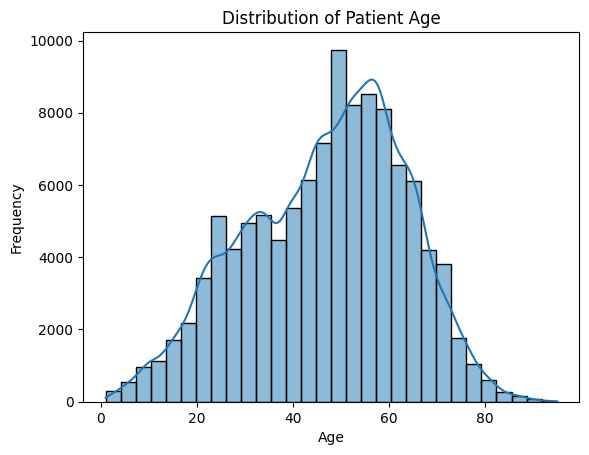

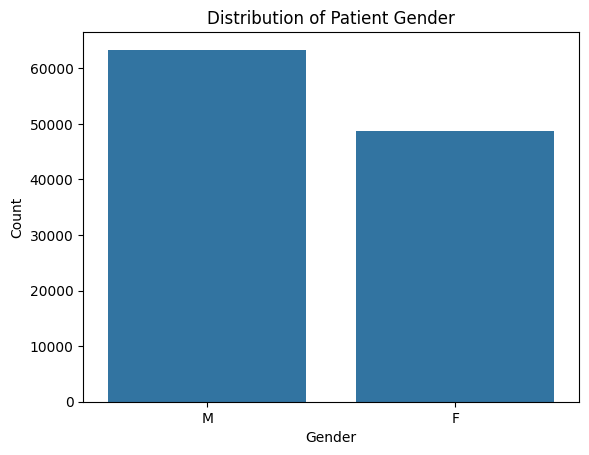

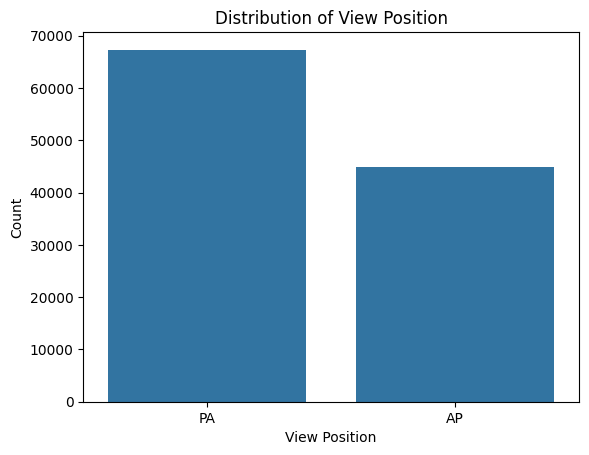

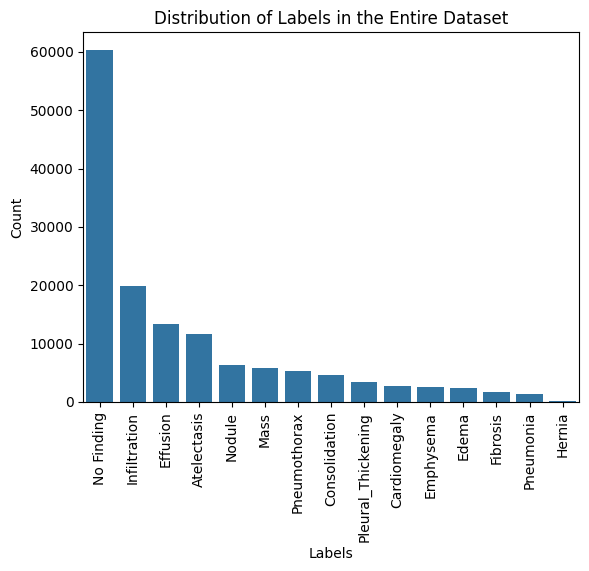

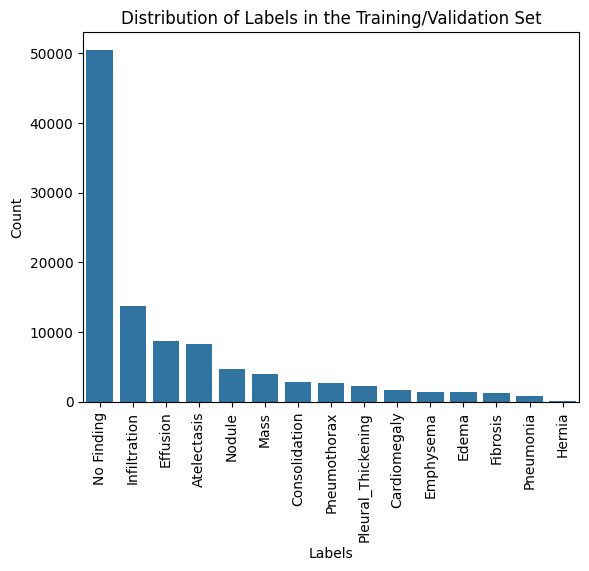

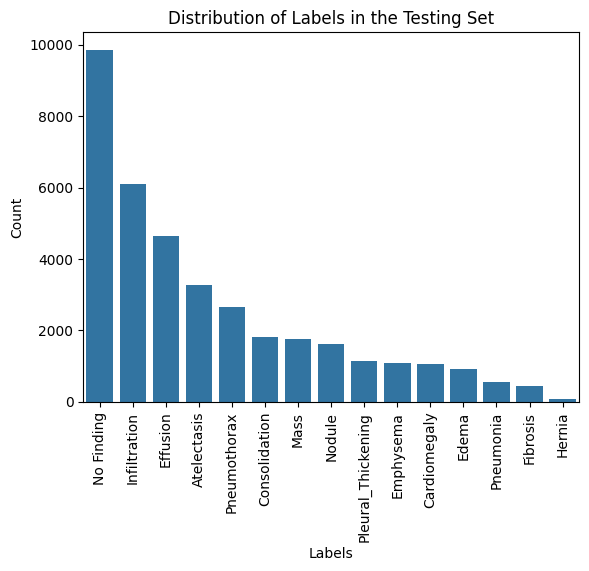

Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112104
Effusion                            0
Infiltration                        0
Pneumothorax                        0
Hernia                              0
Cardiomegaly                        0
Atelectasis                         0
Fibrosis                            0
Mass                                0
Nodule                              0
Consolidation                       0
Emphysema                           0
Pleural_Thickening                  0
Edema                               0
Pneumonia                           0
No Finding  

In [3]:
label_csv_data['Finding Labels'] = label_csv_data['Finding Labels'].str.split('|')
all_labels = set([label for sublist in label_csv_data['Finding Labels'] for label in sublist])
for label in all_labels:
    label_csv_data[label] = label_csv_data['Finding Labels'].apply(lambda x: 1 if label in x else 0)
missing_values = label_csv_data.isnull().sum()

sns.histplot(label_csv_data['Patient Age'], bins=30, kde=True)
plt.title("Distribution of Patient Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

sns.countplot(x='Patient Gender', data=label_csv_data)
plt.title("Distribution of Patient Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

sns.countplot(x='View Position', data=label_csv_data)
plt.title("Distribution of View Position")
plt.xlabel("View Position")
plt.ylabel("Count")
plt.show()

label_counts = label_csv_data[list(all_labels)].sum().sort_values(ascending=False)

sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution of Labels in the Entire Dataset")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

train_val_images = set(train_images)
test_images = set(test_images)

train_val_mask = label_csv_data['Image Index'].isin(train_val_images)
test_mask = label_csv_data['Image Index'].isin(test_images)

train_val_label_counts = label_csv_data[train_val_mask][list(all_labels)].sum().sort_values(ascending=False)
test_label_counts = label_csv_data[test_mask][list(all_labels)].sum().sort_values(ascending=False)

sns.barplot(x=train_val_label_counts.index, y=train_val_label_counts.values)
plt.title("Distribution of Labels in the Training/Validation Set")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

sns.barplot(x=test_label_counts.index, y=test_label_counts.values)
plt.title("Distribution of Labels in the Testing Set")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

missing_values


In [4]:
# Normalizing age, binary encoding gender and view position

scaler = StandardScaler()
label_csv_data_filtered['Age Scaled'] = scaler.fit_transform(label_csv_data_filtered[['Patient Age']])
label_csv_data_filtered['Gender Encoded'] = label_csv_data_filtered['Patient Gender'].map({'F': 0, 'M': 1})
label_csv_data_filtered['View Position Encoded'] = label_csv_data_filtered['View Position'].map({'PA': 0, 'AP': 1})
labels_array = label_csv_data_filtered[list(all_labels)].values
class_weights = {}

In [5]:
def split_train_val(label_data, train_size=0.8):
    """ Split the data into training and validation sets with stratified sampling """
    train_data, val_data = train_test_split(
        label_data,
        test_size=1 - train_size,
        random_state=42
    )
    return train_data, val_data

train_data, val_data = split_train_val(label_csv_data_filtered[train_val_mask_filtered])

for i, label in enumerate(all_labels):
    class_weights[label] = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(label_csv_data_filtered[label]),
        y=label_csv_data_filtered[label]
    )

class_weights = {i: class_weights[label] for i, label in enumerate(all_labels)}

def compute_sample_weights(data, class_weights):
    sample_weights = np.zeros(len(data))    
    for i in range(len(data)):
        sample_labels = labels_array[i]
        weight = 0
        for j, label in enumerate(sample_labels):
            if label == 1:
                weight += class_weights[j][1]
            else:
                weight += class_weights[j][0]
        sample_weights[i] = weight
    
    return sample_weights

train_sample_weights = compute_sample_weights(train_data, class_weights)
val_sample_weights = compute_sample_weights(val_data, class_weights)
test_sample_weights = compute_sample_weights(label_csv_data_filtered[test_mask_filtered], class_weights)

In [6]:
# Skipping hernia since the number of examples of hernia is very low.
# Resampling training dataset to ensure balanced classes in training dataset.

train_label_counts = train_data[list(all_labels)].sum().sort_values(ascending=False)
num_examples = train_label_counts.values[-2]
classes = ['Infiltration', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Cardiomegaly', 'Mass', 'Fibrosis', 'Effusion', 'Edema', 'Consolidation', 'No Finding', 'Nodule', 'Pneumonia', 'Emphysema']

filtered_dfs = []
for label in classes:
    positive_rows = train_data[train_data[label]==1]
    sampled_rows = positive_rows.sample(num_examples)
    filtered_dfs.append(sampled_rows)
downsampled_data = pd.concat(filtered_dfs)

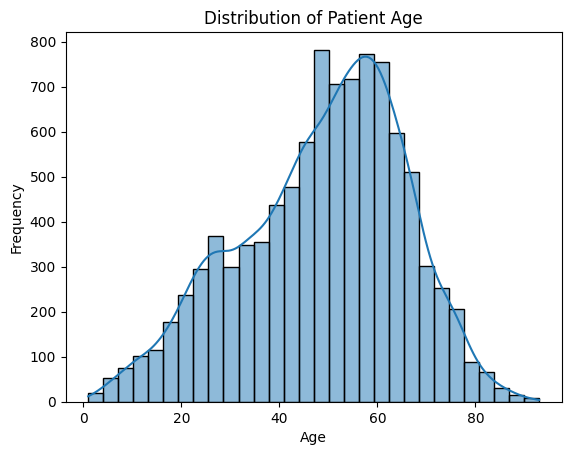

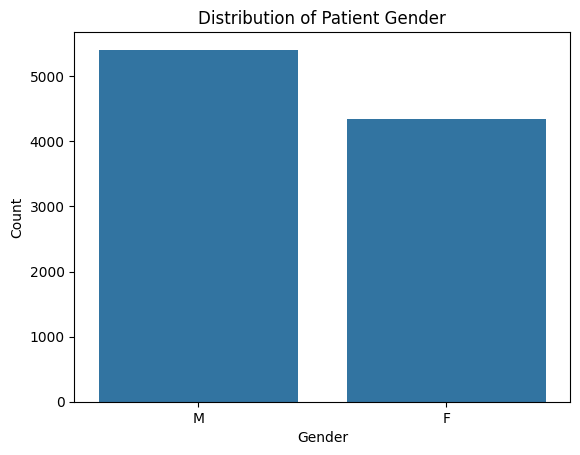

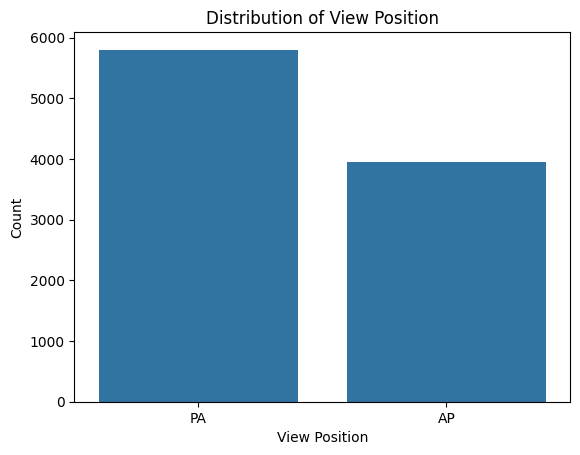

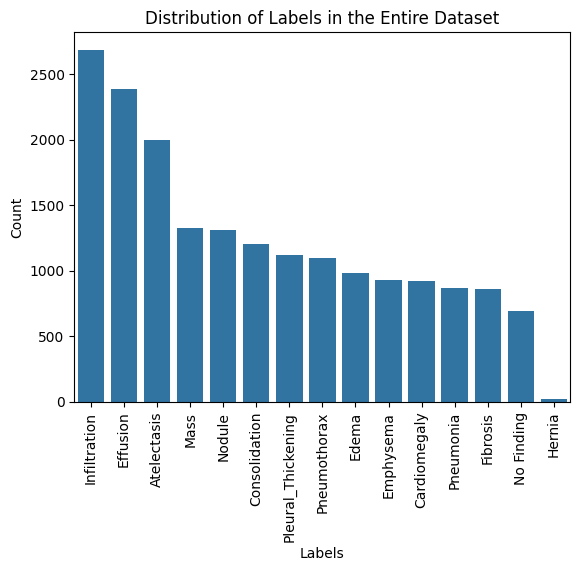

In [7]:
# Plotting distribution of undersampled training dataset

sns.histplot(downsampled_data['Patient Age'], bins=30, kde=True)
plt.title("Distribution of Patient Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

sns.countplot(x='Patient Gender', data=downsampled_data)
plt.title("Distribution of Patient Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

sns.countplot(x='View Position', data=downsampled_data)
plt.title("Distribution of View Position")
plt.xlabel("View Position")
plt.ylabel("Count")
plt.show()

label_counts = downsampled_data[list(all_labels)].sum().sort_values(ascending=False)

sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution of Labels in the Entire Dataset")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [8]:
train_data = downsampled_data
val_data = val_data.sample(len(train_data))

In [9]:
input_size=224
batch_size=16

def fetch_image(image_index, image_size=(input_size, input_size)):
    for folder in folder_list:
        image_path = os.path.join(folder, image_index)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('L')
            image = image.resize(image_size, Image.BILINEAR)
            image = np.array(image, dtype=np.float32) / 255.0
            if len(image.shape) == 2:
                image = np.expand_dims(image,2)
                image = np.repeat(image, 3, axis=-1)
            return image
    raise FileNotFoundError(f"Image {image_index} not found in any folder.")

def tf_dataset_generator(data, batch_size=batch_size, sample_weights=None):
    num_samples = len(data)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    while True:
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            
            batch_images = []
            batch_metadata = []
            batch_labels = []
            batch_sample_weights = []
            
            for idx in batch_indices:
                image_index = data.iloc[idx]['Image Index']
                image = fetch_image(image_index)
                age = data.iloc[idx]['Age Scaled']
                gender = data.iloc[idx]['Gender Encoded']
                view_position = data.iloc[idx]['View Position Encoded']
                
                metadata = np.array([age, gender, view_position], dtype=np.float32)
                labels = np.array(labels_array[idx], dtype=np.float32)
                
                batch_images.append(image)
                batch_metadata.append(metadata)
                batch_labels.append(labels)
                
                if sample_weights is not None:
                    batch_sample_weights.append(sample_weights[idx])
            
            batch_images = np.array(batch_images, dtype=np.float32)
            batch_metadata = np.array(batch_metadata, dtype=np.float32)
            batch_labels = np.array(batch_labels, dtype=np.float32)
            
            if sample_weights is not None:
                batch_sample_weights = np.array(batch_sample_weights, dtype=np.float32)
                yield ((batch_images, batch_metadata), batch_labels, batch_sample_weights)
            else:
                yield ((batch_images, batch_metadata), batch_labels)


# train_generator = tf_dataset_generator(train_data, sample_weights=train_sample_weights)
# val_generator = tf_dataset_generator(val_data, sample_weights=val_sample_weights)
# test_generator = tf_dataset_generator(label_csv_data_filtered[test_mask_filtered], sample_weights=test_sample_weights)

train_generator = tf_dataset_generator(train_data, sample_weights=None)
val_generator = tf_dataset_generator(val_data, sample_weights=None)
test_generator = tf_dataset_generator(label_csv_data_filtered[test_mask_filtered], sample_weights=None)


train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        (tf.TensorSpec(shape=(None, input_size, input_size, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None, len(all_labels)), dtype=tf.float32),
        #  tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        (tf.TensorSpec(shape=(None, input_size, input_size, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None, len(all_labels)), dtype=tf.float32),
        #  tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        (tf.TensorSpec(shape=(None, input_size, input_size, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None, len(all_labels)), dtype=tf.float32),
        #  tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

2024-09-09 09:44:36.640254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-09 09:44:36.722396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-09 09:44:36.722861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-09 09:44:36.725436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
metadata_input = Input(shape=(3,))

x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x) 
# x = Concatenate()([x, metadata_input])
x = Dropout(0.1)(x) 
x = Dense(128, activation='relu')(x)
output = Dense(len(all_labels), activation='sigmoid')(x)

model = Model(inputs=[base_model.input, metadata_input], outputs=output)
auc_metrics = [tf.keras.metrics.AUC(name=f'auc_class_{i}') for i in range(len(all_labels))]

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    # metrics=['accuracy'] + auc_metrics
    metrics = ['accuracy', 'AUC', 'Precision', 'Recall']
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [15]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(train_data) // batch_size,
    validation_steps=len(val_data) // batch_size,
)
model.save('trained_model5')

Epoch 1/10
609/609 [==============================] - 297s 483ms/step - loss: 0.2136 - accuracy: 0.5581 - auc: 0.8156 - precision: 0.5679 - recall: 0.3857 - val_loss: 0.2091 - val_accuracy: 0.5704 - val_auc: 0.8282 - val_precision: 0.5706 - val_recall: 0.4672
Epoch 2/10
609/609 [==============================] - 300s 493ms/step - loss: 0.2083 - accuracy: 0.5704 - auc: 0.8273 - precision: 0.5713 - recall: 0.4335 - val_loss: 0.2088 - val_accuracy: 0.5704 - val_auc: 0.8290 - val_precision: 0.5704 - val_recall: 0.4685
Epoch 3/10
609/609 [==============================] - 298s 490ms/step - loss: 0.2076 - accuracy: 0.5704 - auc: 0.8295 - precision: 0.5705 - recall: 0.4433 - val_loss: 0.2092 - val_accuracy: 0.5704 - val_auc: 0.8285 - val_precision: 0.5703 - val_recall: 0.4677
Epoch 4/10
609/609 [==============================] - 301s 495ms/step - loss: 0.2067 - accuracy: 0.5704 - auc: 0.8324 - precision: 0.5702 - recall: 0.4524 - val_loss: 0.2095 - val_accuracy: 0.5704 - val_auc: 0.8287 - val

INFO:tensorflow:Assets written to: trained_model5/assets


INFO:tensorflow:Assets written to: trained_model5/assets


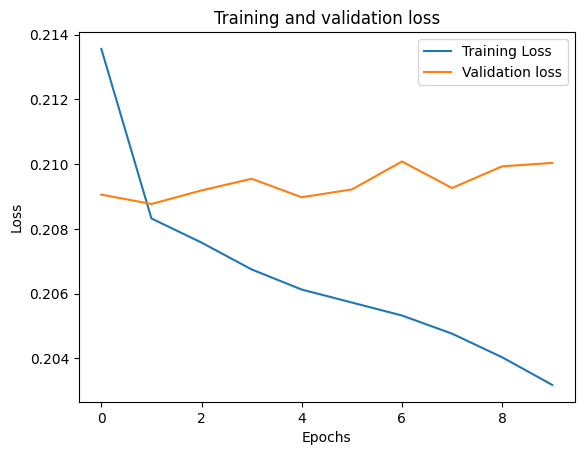

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

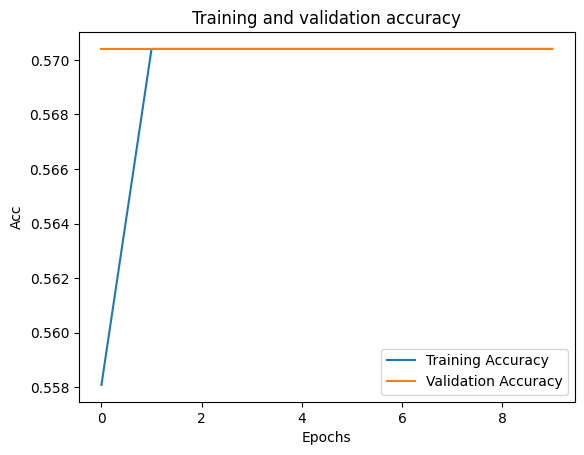

In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

#### Testing trained models:
##### 1. Resnet50 trained on the entire dataset for 10 epochs with sample weights with metadata as a feature and a 1024->15 MLP as the final layers
##### 2. Resnet50 trained on the entire dataset for 50 epochs with metadata as a feature and a 1024->15 MLP as the final layers
##### 3. Resnet50 trained on the downsampled dataset for 10 epochs with metadata as a feature and a 1024->15 MLP as the final layers
##### 4. MobileNetV2 trained on the downsampled dataset for 10 epochs with metadata as a feature and a 256->128->15 MLP as the final layers
##### 5. MobileNetV2 trained on the downsample dataset for 10 epochs without metadata as a feature and a 256->128->15 MLP as the final layers

In [10]:
def plot_multilabel_roc(y_true, y_pred, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random predictions
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    plt.show()

In [28]:
def test_network(model):
    test_predictions, test_labels = [], []
    i = 0
    for data in tqdm(test_dataset, total=len(label_csv_data_filtered[test_mask_filtered])//batch_size, position=0, leave=True):
        if data[1].shape[0] == batch_size:
            test_labels.append(data[1])
            test_predictions.append(model.predict(data[0],verbose=0))
        i += 1
        if i == len(label_csv_data_filtered[test_mask_filtered])//batch_size:
            break
    test_predictions = np.array(test_predictions).reshape(-1,15)
    test_labels = np.array(test_labels).reshape(-1,15)
    print(test_predictions.shape, test_labels.shape)
    plot_multilabel_roc(test_labels, test_predictions, 15)

  0%|          | 0/1599 [00:00<?, ?it/s]

(25568, 15) (25568, 15)


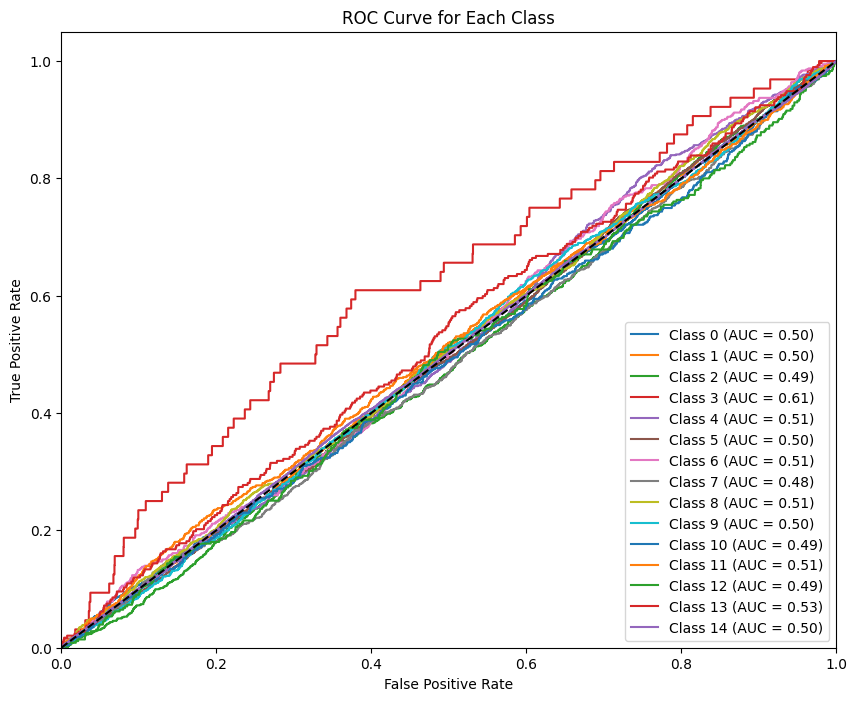

  0%|          | 0/1599 [00:00<?, ?it/s]

(25568, 15) (25568, 15)


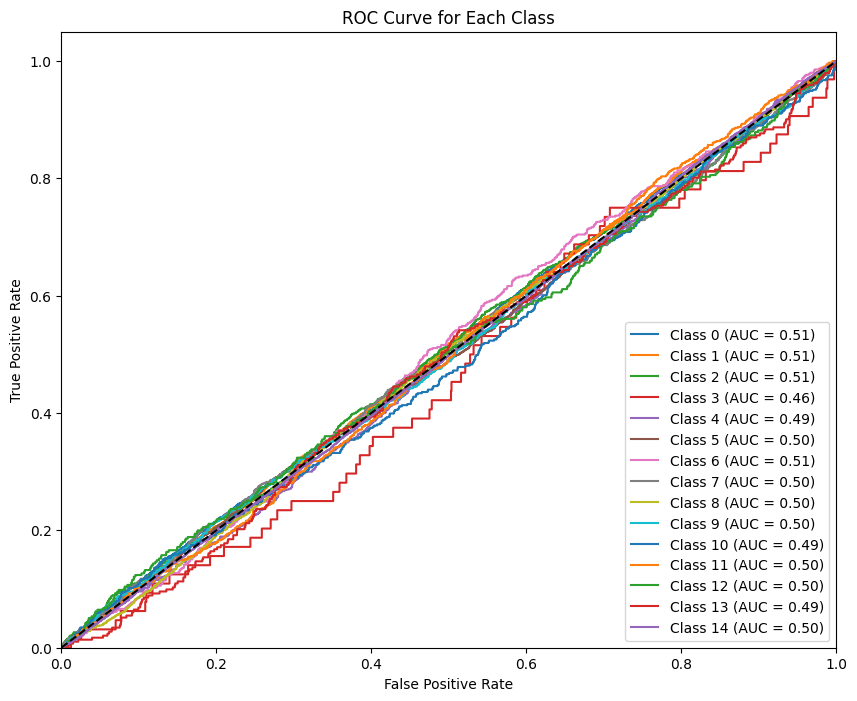

  0%|          | 0/1599 [00:00<?, ?it/s]

(25568, 15) (25568, 15)


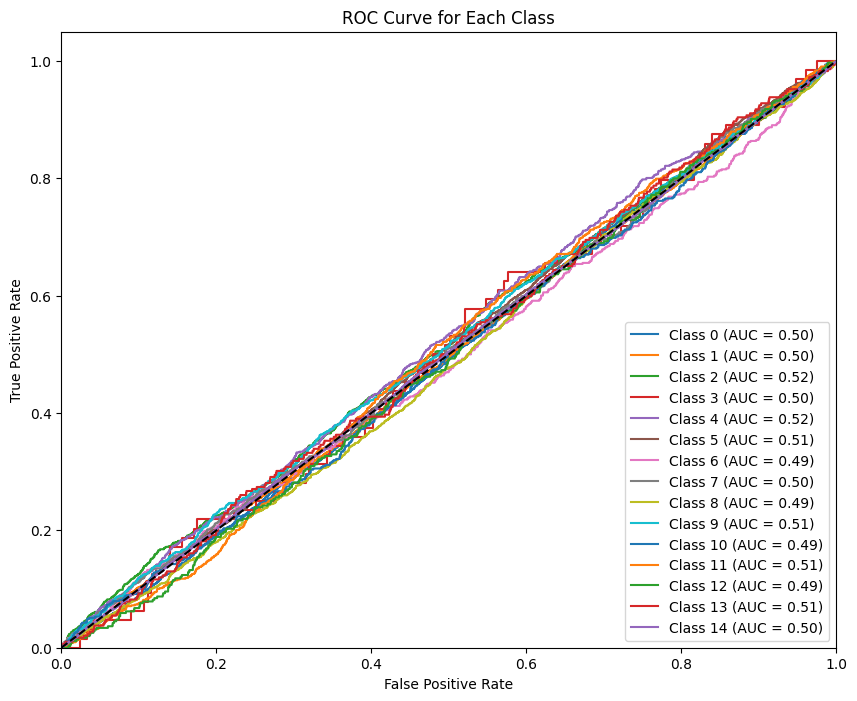

  0%|          | 0/1599 [00:00<?, ?it/s]

(25568, 15) (25568, 15)


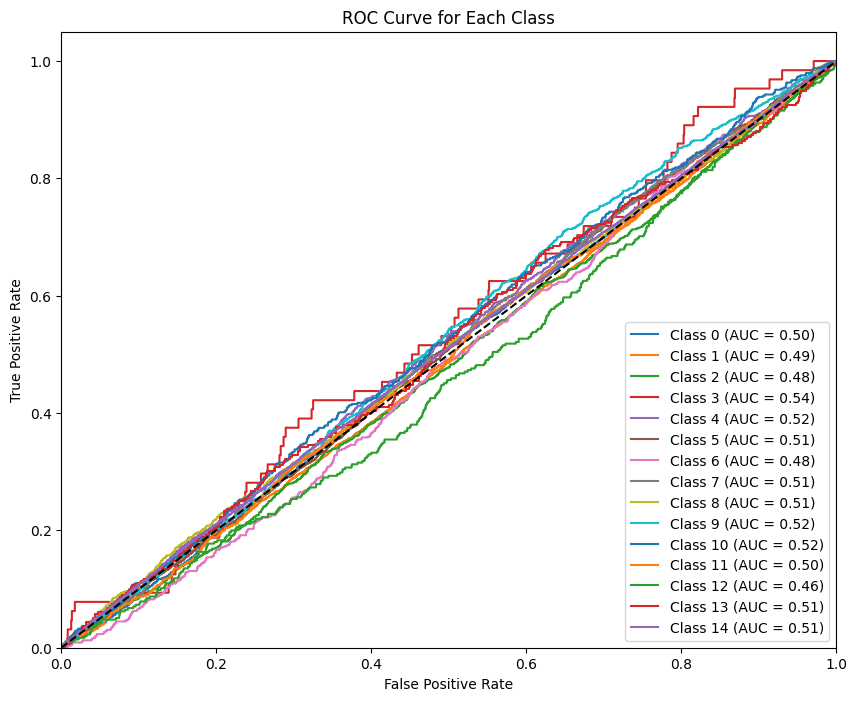

  0%|          | 0/1599 [00:00<?, ?it/s]

(25568, 15) (25568, 15)


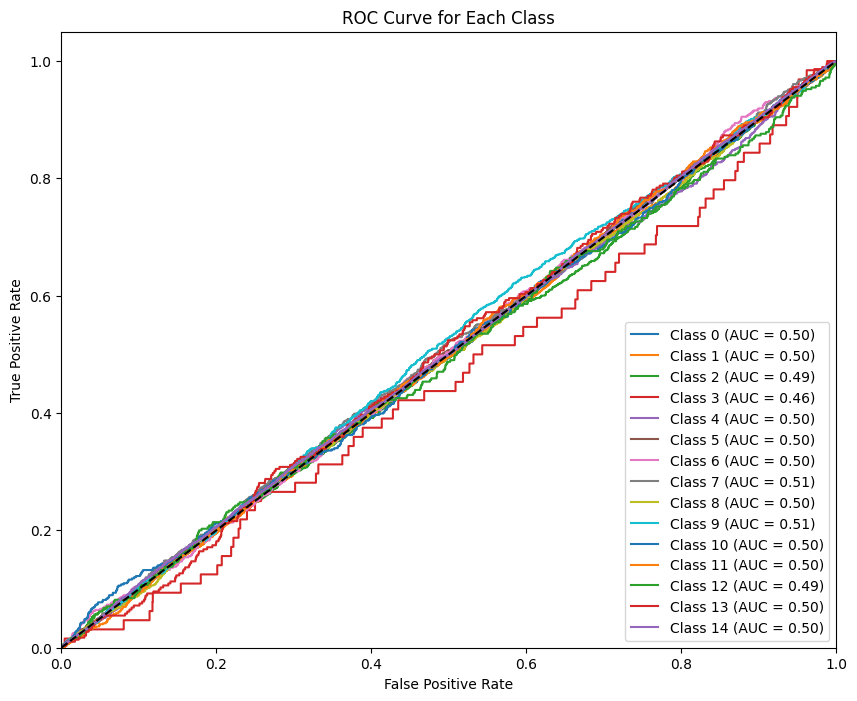

In [29]:
models = ['trained_model', 'trained_model2', 'trained_model3', 'trained_model4', 'trained_model5']
for model_name in models:
    model = tf.keras.models.load_model(model_name)
    test_network(model)